In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.cm as cm

from keras.utils import to_categorical
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# os.environ["CUDA_VISIBLE_DEVICES"] = '1'
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device

Using TensorFlow backend.


device(type='cpu')

In [2]:
def duplicate(df, n) :
    df_result = pd.DataFrame()
    for c in df.columns :
        df_result[c] = df[c].repeat(n)
    df_result = df_result.reset_index(drop=True)
    return df_result

def pairing(df_base, df_additional) :
    n = len(df_base)
    df_base = duplicate(df_base, len(df_additional))
    df_base['LONGITUDE_SOURCE'] = pd.np.tile(df_additional.LONGITUDE, n) 
    df_base['LATITUDE_SOURCE'] = pd.np.tile(df_additional.LATITUDE, n) 
    df_base['SIGNAL_SOURCE'] = pd.np.tile(df_additional.SIGNAL, n) 
    return df_base

def merge_agg(df, group, value, aggregates, columns=None) :
    df_count = pd.DataFrame(df.groupby(group)[value].agg(aggregates)).reset_index()
    df_count.columns = group + aggregates if columns is None else group + columns
    df = df.merge(df_count, on=group, how="left").fillna(0)
    return df

def restructure(df) :
    df_final = pd.DataFrame()
    for i in range(1,521) :
        AP = 'WAP%03d' % i
        df_temp = df[[AP, 'LONGITUDE', 'LATITUDE', 'BUILDINGID', 'FLOOR']]
        df_temp = df_temp.rename(columns={AP : 'SIGNAL'})
        df_temp['WAP'] = i
        
        df_final = df_final.append(df_temp, ignore_index=True)
    df_final = df_final.drop_duplicates().reset_index(drop=True)
    return df_final

def get_strongest(df) :
    df_max = pd.DataFrame()
    for WAP in range(1,521) :
        df_temp = df[df['WAP'] == WAP].reset_index(drop=True)
        max_val = df_temp['SIGNAL'].max()
        
        df_temp = df_temp[df_temp['SIGNAL'] == max_val]
        df_temp = df_temp.drop_duplicates().reset_index(drop=True)
        
        df_max = df_max.append(df_temp).reset_index(drop=True)

    return df_max
    
    
def generate(df, df_max, building_id, floor):
    curr_df = df[(df['BUILDINGID']==building_id) & (df['FLOOR']==floor)].reset_index(drop=True)
    curr_df_max = df_max[(df_max['BUILDINGID']==building_id) & (df_max['FLOOR']==floor)].reset_index(drop=True)
    max_curr_floor = curr_df_max['WAP'].unique()

    df_final = pd.DataFrame()
    for i in max_curr_floor :
        df_temp = curr_df[curr_df['WAP']==i][['WAP', 'LONGITUDE', 'LATITUDE', 'SIGNAL']]

        #add pairing
        curr_df_max_by_WAP = curr_df_max[curr_df_max['WAP']==i]
        df_temp = pairing(df_temp, curr_df_max_by_WAP)
        df_temp['DIFF_SIGNAL'] = df_temp['SIGNAL_SOURCE'] - df_temp['SIGNAL']

        df_final = df_final.append(df_temp, ignore_index=True)

    return df_final, curr_df_max

In [3]:
df_train = pd.DataFrame.from_csv('../data/ujiindoorloc/trainingData.csv').reset_index()
df_val = pd.DataFrame.from_csv('../data/ujiindoorloc/validationData.csv').reset_index()
df_ori = df_train.append(df_val, ignore_index=True)

df_restructure_train = restructure(df_train)
df_restructure_train.to_csv('../data/ujiindoorloc/restructured_train.csv')
df_restructure_val = restructure(df_val)
df_restructure_val.to_csv('../data/ujiindoorloc/restructured_val.csv')
df_restructure = restructure(df_ori)
df_restructure.to_csv('../data/ujiindoorloc/restructured_all.csv')

# df_restructure_train = pd.DataFrame.from_csv('../data/ujiindoorloc/restructured_train.csv')
# df_restructure_val = pd.DataFrame.from_csv('../data/ujiindoorloc/restructured_val.csv')
# df_restructure = pd.DataFrame.from_csv('../data/ujiindoorloc/restructured_all.csv')

df_restructure_train['LONGITUDE'] = minmax_scale(df_restructure_train['LONGITUDE'], feature_range=(-1, 1))
df_restructure_train['LATITUDE'] = minmax_scale(df_restructure_train['LATITUDE'], feature_range=(-1, 1))

df_restructure['LONGITUDE'] = minmax_scale(df_restructure['LONGITUDE'], feature_range=(-1, 1))
df_restructure['LATITUDE'] = minmax_scale(df_restructure['LATITUDE'], feature_range=(-1, 1))

df_restructure_val['LONGITUDE'] = minmax_scale(df_restructure_val['LONGITUDE'], feature_range=(-1, 1))
df_restructure_val['LATITUDE'] = minmax_scale(df_restructure_val['LATITUDE'], feature_range=(-1, 1))

/home/tryan/miniconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.
/home/tryan/miniconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  


In [5]:
group = ['LONGITUDE', 'LATITUDE', 'BUILDINGID', 'FLOOR', 'WAP']
df_agg_max = merge_agg(df_restructure, group, 'SIGNAL', ['max'], ['MAX'])

In [6]:
df_detected = df_agg_max[df_agg_max['MAX']<100].drop('MAX', axis=1)
df_detected['SIGNAL'] = minmax_scale(df_detected['SIGNAL'], feature_range=(-1, 1))

In [7]:
df_detected = merge_agg(df_detected, group, 'SIGNAL', ['mean'])
df_detected = df_detected.drop('SIGNAL', axis=1).rename(columns={'mean' : 'SIGNAL'})
df_detected = df_detected.drop_duplicates().reset_index(drop=True)

In [8]:
df_max = get_strongest(df_detected)

In [9]:
df_data, curr_df_max = generate(df_detected, df_max, building_id=0, floor=0)
train_data, val_data = train_test_split(df_data, test_size=0.2, random_state=42)

In [10]:
colors = cm.rainbow(np.linspace(0, 1, len(df_data.WAP.unique())))
color_dict = {i:c for i, c in zip(df_data.WAP.unique(), colors)}
color_wap = [color_dict[x] for x in df_data.WAP]

11


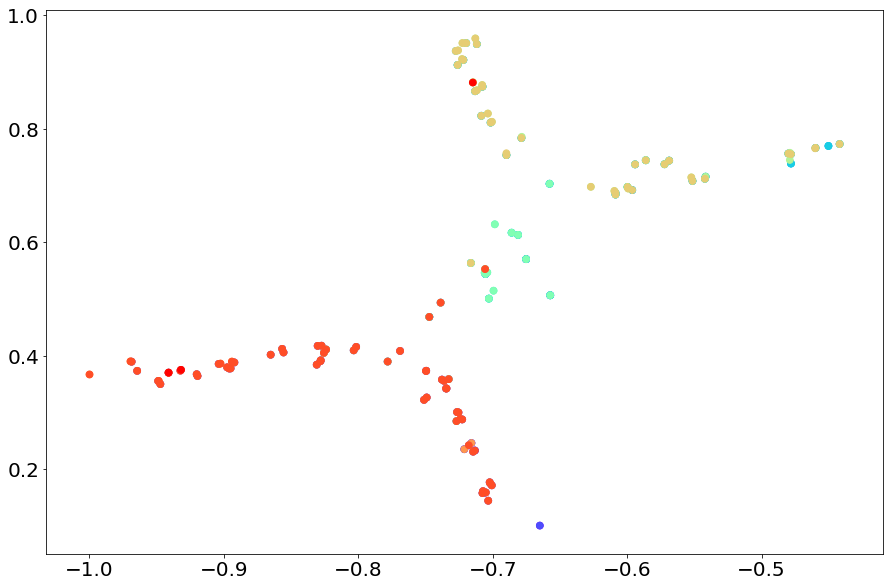

In [11]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.tick_params(labelsize=20)
ax.scatter(df_data['LONGITUDE'], df_data['LATITUDE'], s=45, c=color_wap)
print(len(colors))
plt.show()

In [12]:
class UJIIndoorLocDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.features = self.df.drop(['WAP', 'SIGNAL', 'SIGNAL_SOURCE', 'DIFF_SIGNAL'], axis=1).values
        self.labels = self.df['DIFF_SIGNAL'].values 

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx,:2], self.features[idx,2:], self.labels[idx]
#         return self.features[idx], self.labels[idx]

In [13]:
batch_size = 64
all_dataset = UJIIndoorLocDataset(df_data)
all_dataloader = DataLoader(all_dataset, batch_size=batch_size, shuffle=True)
all_dataset.__len__()

484

In [14]:
# https://github.com/L1aoXingyu/pytorch-beginner/tree/master/08-AutoEncoder
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 32),
            nn.Dropout(0.2),
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 3))

    def forward(self, x1, x2=None, predict=False):
        out1 = self.encoder(x1)
        
        if predict :
            return out1
        
        out2 = self.encoder(x2)
        distance = torch.sqrt(torch.sum((out1 - out2)**2, dim=1))
        return distance

In [15]:
num_epochs = 100
learning_rate = 1e-1
model = autoencoder().to(device).float()
criterion = nn.MSELoss().to(device)

def exp_lr_scheduler(optimizer, epoch, lr_decay=0.1, lr_decay_epoch=5):
    if epoch % lr_decay_epoch:
        return optimizer
    
    for param_group in optimizer.param_groups:
        new_lr = param_group['lr'] / (1+lr_decay*epoch)
        param_group['lr'] = new_lr
    return optimizer

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-2)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-5)
optimizer = exp_lr_scheduler(optimizer, num_epochs, lr_decay=1e-2, lr_decay_epoch=10)

In [16]:
losses = []
for epoch in range(num_epochs):
    for features1, features2, labels in all_dataloader:
        features1 = features1.to(device)
        features2 = features2.to(device)
        labels = labels.to(device)
        # ===================forward=====================
        distance = model(features1.float(), features2.float())
        loss = criterion(distance, labels.float())
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    losses.append(loss.item())
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss.item()))

epoch [1/100], loss:0.2345
epoch [2/100], loss:0.2309
epoch [3/100], loss:0.2090
epoch [4/100], loss:0.1667
epoch [5/100], loss:0.1201
epoch [6/100], loss:0.1193
epoch [7/100], loss:0.1272
epoch [8/100], loss:0.1273
epoch [9/100], loss:0.1497
epoch [10/100], loss:0.0702
epoch [11/100], loss:0.0981
epoch [12/100], loss:0.1015
epoch [13/100], loss:0.1069
epoch [14/100], loss:0.1600
epoch [15/100], loss:0.0836
epoch [16/100], loss:0.1207
epoch [17/100], loss:0.1020
epoch [18/100], loss:0.1220
epoch [19/100], loss:0.1488
epoch [20/100], loss:0.0970
epoch [21/100], loss:0.1114
epoch [22/100], loss:0.0778
epoch [23/100], loss:0.1302
epoch [24/100], loss:0.1049
epoch [25/100], loss:0.1476
epoch [26/100], loss:0.1086
epoch [27/100], loss:0.1104
epoch [28/100], loss:0.0833
epoch [29/100], loss:0.0993
epoch [30/100], loss:0.0603
epoch [31/100], loss:0.0722
epoch [32/100], loss:0.1222
epoch [33/100], loss:0.0973
epoch [34/100], loss:0.1021
epoch [35/100], loss:0.1229
epoch [36/100], loss:0.0797
e

<function matplotlib.pyplot.show(*args, **kw)>

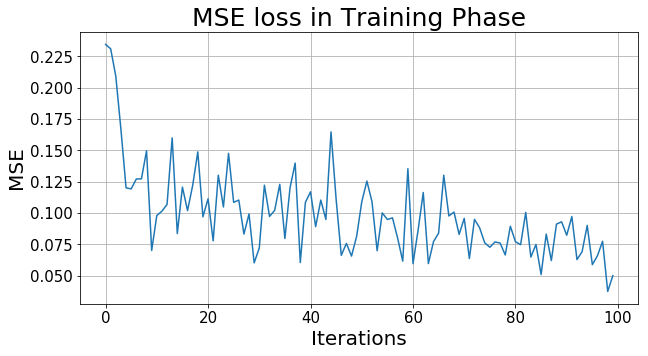

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Iterations', fontsize=20)
plt.ylabel('MSE', fontsize=20)
plt.tick_params(labelsize=15)
plt.title('MSE loss in Training Phase', fontsize=25)
plt.grid(True)
plt.show

In [18]:
model.eval()

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Dropout(p=0.2)
    (2): Linear(in_features=32, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=3, bias=True)
  )
)

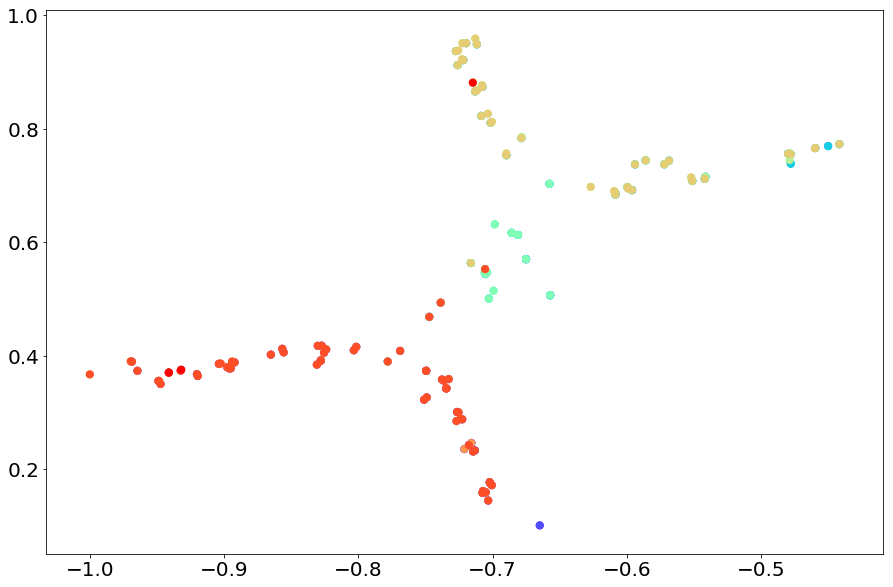

Text(0.5, 0, 'z')

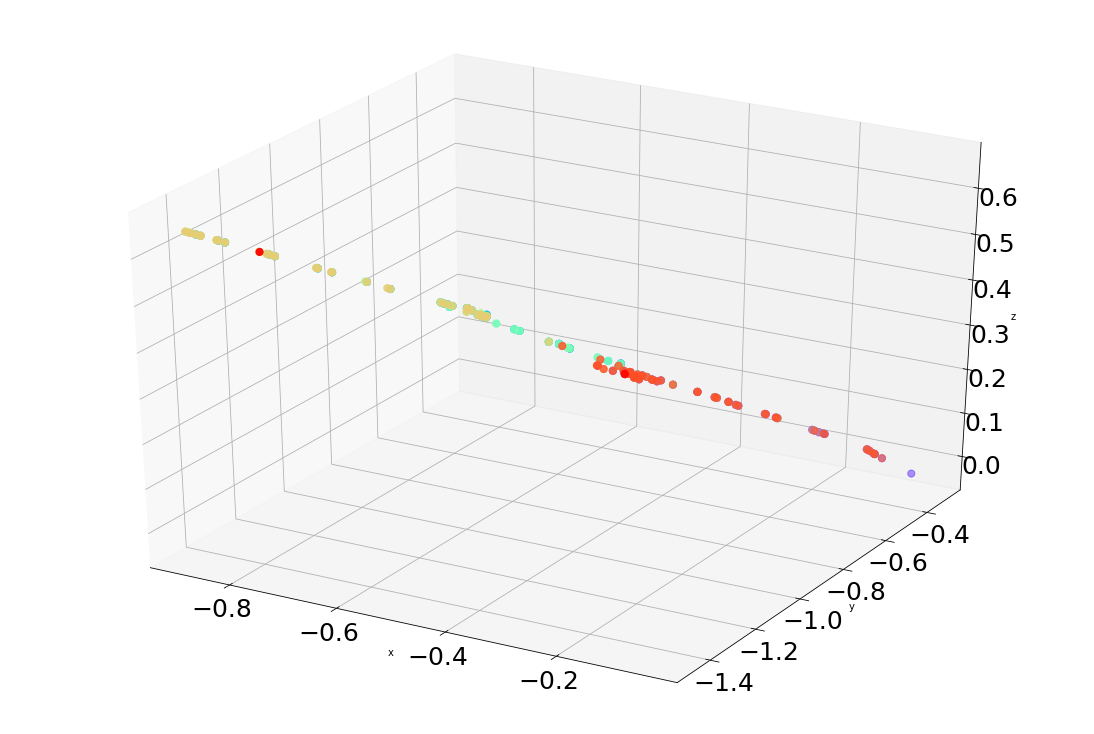

In [19]:
# http://www.analyzingdata.org/portfolio/003-Indoor_localization_Wifi_Footprint/
x = df_data['LONGITUDE']
y = df_data['LATITUDE']
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.tick_params(labelsize=20)
ax.scatter(x, y, c=color_wap, s=50)

features = df_data[['LONGITUDE', 'LATITUDE']].values
features = torch.tensor(features).to(device).float()
out = model(features, predict=True)
out = out.cpu().detach().numpy()

# for i in range(len(out)) :
#     ax.annotate(i, (x[i], y[i]), fontsize=5)
plt.show()

fig = plt.figure(figsize=(15,10))
ax = Axes3D(fig)
ax.tick_params(labelsize=25)

ax.scatter(out[:, 0], out[:, 1], out[:, 2], c=color_wap, s=50)
# for i, x in zip(range(len(out)), df_data.WAP) :
#     ax.text(out[i, 0], out[i, 1], out[i, 2],i, fontsize=5)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

In [20]:
floor = curr_df_max.FLOOR.unique()[0]
bid = curr_df_max.BUILDINGID.unique()[0]
max_curr_floor = curr_df_max['WAP'].unique()

In [21]:
curr_coverage = df_agg_max[(df_agg_max.BUILDINGID==bid)&(df_agg_max.FLOOR==floor)]
curr_coverage = curr_coverage[['LONGITUDE', 'LATITUDE', 'WAP', 'MAX']]
curr_coverage = curr_coverage.drop_duplicates().reset_index(drop=True)

curr_coverage_hole = curr_coverage[curr_coverage['MAX']==100]
curr_coverage_hole = curr_coverage_hole[['LONGITUDE', 'LATITUDE', 'WAP']]
curr_coverage_hole = curr_coverage_hole.drop_duplicates().reset_index(drop=True)

In [22]:
real_hole_candidates = []
detected_hole = []
errors = []

y_pred = np.array([])
y_true = np.array([])

for i in max_curr_floor :
    curr_df = curr_coverage[curr_coverage.WAP == i].copy()
    features = curr_df[['LONGITUDE', 'LATITUDE']].values
    features = torch.tensor(features).to(device).float()
    
    source = curr_df_max[curr_df_max.WAP==i][['LONGITUDE', 'LATITUDE']].values[0]
    sources = np.tile(source, (len(features), 1))
    sources = torch.tensor(sources).to(device).float()
    
    out = model(features,sources)
    out = out.cpu().detach().numpy()
    curr_df['DISTANCE'] = out
    
    detected = curr_df[(curr_df.MAX<100)]
    lon_min, lon_max = detected.LONGITUDE.min(), detected.LONGITUDE.max()
    lat_min, lat_max = detected.LATITUDE.min(), detected.LATITUDE.max()
    max_distance = 0.9*detected['DISTANCE'].max()
    
    temp = curr_df.loc[(lon_min<curr_df.LONGITUDE)&(curr_df.LONGITUDE<lon_max)]
    temp = temp.loc[(lat_min<curr_df.LATITUDE)&(curr_df.LATITUDE<lat_max)]
    real_hole_candidate = temp[temp.MAX==100]
    hole_candidate = temp[temp['DISTANCE']>max_distance]
    count = np.sum(hole_candidate.MAX == 100)
    err = np.mean(hole_candidate.MAX < 100)
    
    all_real_hole_candidate = curr_df[curr_df.MAX==100]
    all_hole_candidate = curr_df[curr_df['DISTANCE']>max_distance]
    all_count = np.sum(all_hole_candidate.MAX == 100)
    all_err = np.mean(all_hole_candidate.MAX < 100)
    
    dist = minmax_scale(curr_df.DISTANCE.values, feature_range=(0, 1)) 
    y_pred = np.concatenate((y_pred, dist))
    y_true = np.concatenate((y_true, curr_df.MAX == 100))
    
    errors.append(err)
    detected_hole.append(len(hole_candidate))
    real_hole_candidates.append(len(real_hole_candidate))
#     print('WAP_'+str(i), len(real_hole_candidate), len(hole_candidate), count, err)
    print('WAP_'+str(i), len(all_real_hole_candidate), len(all_hole_candidate), all_count, all_err)
    
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)
auc

WAP_53 72 65 62 0.046153846153846156
WAP_54 71 65 61 0.06153846153846154
WAP_57 98 28 24 0.14285714285714285
WAP_58 96 27 24 0.1111111111111111
WAP_71 108 41 40 0.024390243902439025
WAP_72 110 41 40 0.024390243902439025
WAP_75 89 77 76 0.012987012987012988
WAP_76 90 77 76 0.012987012987012988
WAP_80 70 29 22 0.2413793103448276
WAP_81 71 31 24 0.22580645161290322
WAP_300 129 16 15 0.0625


0.7852740822424586

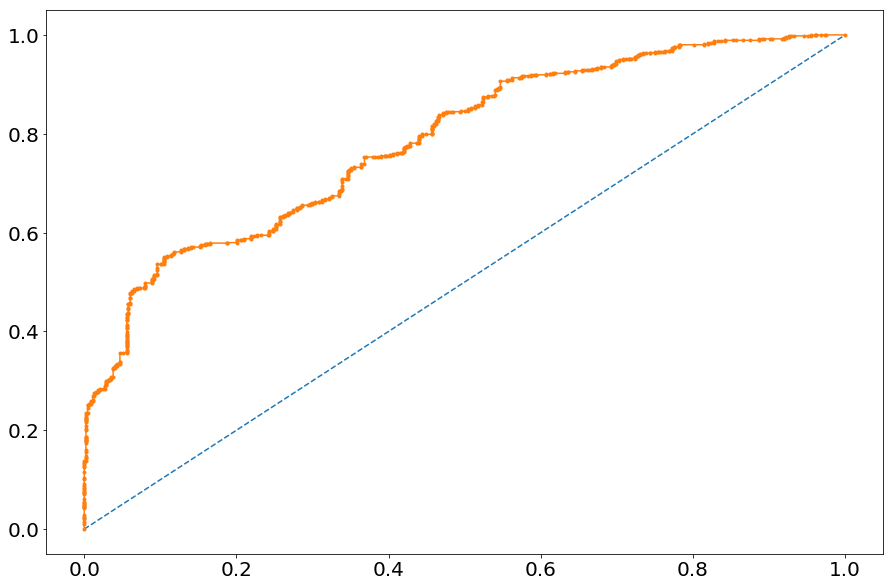

In [23]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.tick_params(labelsize=20)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

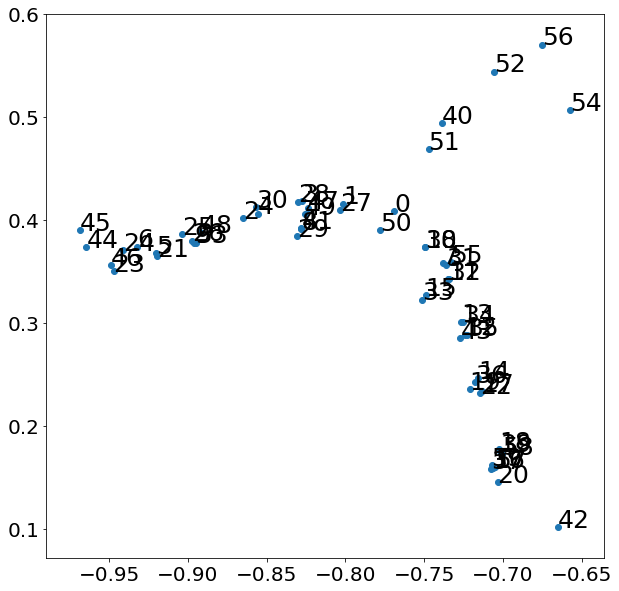

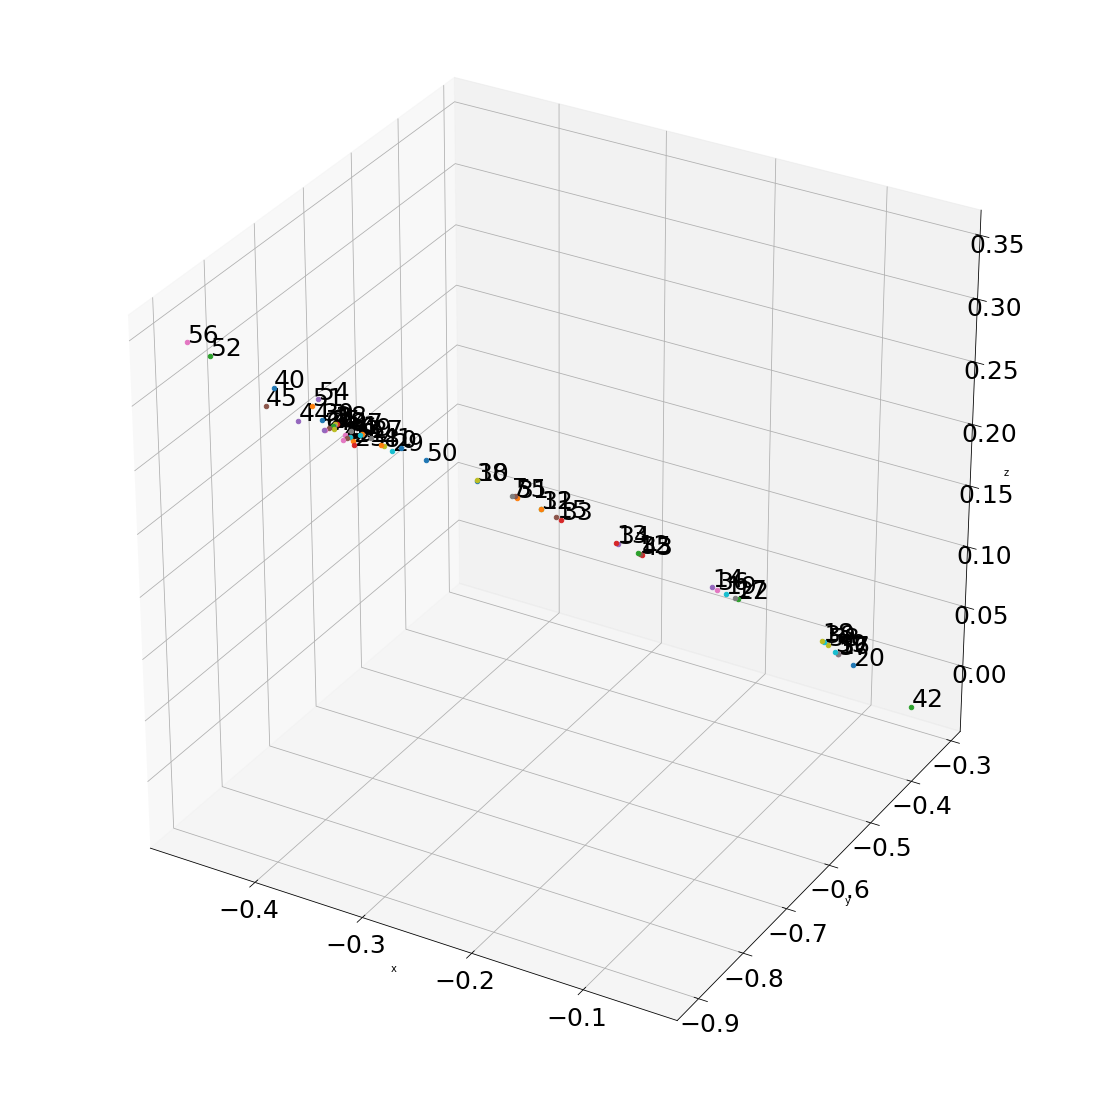

In [24]:
for i in max_curr_floor :
    x = df_data[df_data['WAP']==i]['LONGITUDE']
    y = df_data[df_data['WAP']==i]['LATITUDE']
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.tick_params(labelsize=20)
    ax.scatter(x, y)
    
    features = df_data[df_data['WAP']==i][['LONGITUDE', 'LATITUDE']].values
    features = torch.tensor(features).to(device).float()
    out = model(features, predict=True)
    out = out.cpu().detach().numpy()

    for i in range(len(out)) :
        ax.annotate(i, (x[i], y[i]), fontsize=25)
    plt.show()
    
    
    fig = plt.figure(figsize=(15,15))
    ax = Axes3D(fig)
    ax.tick_params(labelsize=25)
    
    for i in range(len(out)) :
        ax.scatter(out[i, 0], out[i, 1], out[i, 2])
        ax.text(out[i, 0], out[i, 1], out[i, 2],i, fontsize=25)
        
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    break